# 1. Set up

In [6]:
# importing relevant packages
import sys
import requests
import json
import pandas as pd
import networkx as nx
import pathpy as pp
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
import math
import scipy
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import planarity
import numpy as np
import nbimporter

# importing my own functions
import MT_functions as mt
 
%matplotlib inline

from tqdm import tqdm
from community import community_louvain
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform 
from IPython.core.display import display, HTML
from pandas import DataFrame
from pandas.io.json import json_normalize 
from itertools import count
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [7]:
# set working directory
PATH = (r'/Users/arnau/OneDrive/Bureau/MT/Data/')
sys.path.append(PATH)

# define data name
DATANAME = 'API_data_yhfin_complete.csv'

# load data using pandas
data_yhfin_complete = pd.read_csv(PATH + DATANAME)
data_yhfin_complete['Date'] = pd.to_datetime(data_yhfin_complete['Date'])
data_yhfin_complete.set_index('Date', inplace=True)

# 2. Building time windows

In [8]:
# selecting the SP500 components
prices=data_yhfin_complete[["AAPL", "BC", "EA", "IBM",'NVDA',"UPS", "TXN", "WMT"]]

# computing the log returns
simpl_R = prices.pct_change()
log_R = np.log(1+simpl_R)
log_R = log_R.iloc[1:]
log_R.head()

,AAPL,BC,EA,IBM,NVDA,UPS,TXN,WMT
Date,,,,,,,,
2010-01-04,0.015445,0.052865,0.022285,0.011772,-0.010223,0.014020,-0.001921,0.014487
2010-01-05,0.001727,0.017019,0.027712,-0.012154,0.014497,0.001717,-0.005784,-0.010007
2010-01-06,-0.016034,0.013120,-0.026060,-0.006518,0.006376,-0.007405,-0.007374,-0.002238
2010-01-07,-0.001850,-0.005809,-0.007731,-0.003467,-0.019792,-0.007635,0.003112,0.000560
2010-01-08,0.006626,-0.010249,0.019759,0.009985,0.002159,0.046955,0.022654,-0.005050


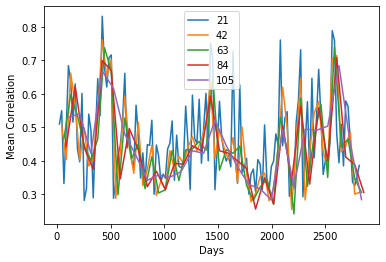

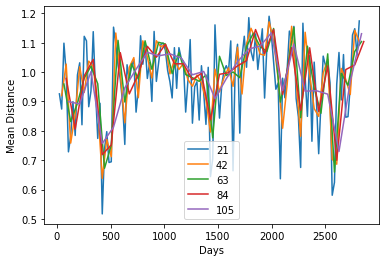

100%|██████████| 40/40 [00:00<00:00, 240.04it/s]


In [9]:
# plotting the evolution of the mean correlation for a range of time windows
t = 1
corr_dict = {}
T = 1
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(log_R),W):
            dkey = i
            corr_dict[dkey]=log_R.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(0,inplace=True)
            x.append(dkey+W)
            y.append(np.mean([abs(j) for j in corr_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Correlation')
    plt.legend(list(range(21,168,21)))
plt.show()

# plotting the evolution of the mean distance for a range of time windows
corr_dict = {}
dist_dict = {}
T = 1
x = []
y = []
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(log_R),W):
            dkey = i
            corr_dict[dkey]=log_R.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(1,inplace=True)
            dist_dict[dkey] = corr_dict[dkey].applymap(mt.dist)
            x.append(dkey+W)
            y.append(np.mean([abs(j) for j in dist_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Distance')
    plt.legend(list(range(21,126,21)))
plt.show()

# building the networks for the different time windows
W = 378
delta= 63
corr_dict = {}
dist_dict = {}
for j in tqdm(range(100)):
    for i in range(t,len(log_R)-W+delta, delta): 
        dkey = i
        corr_dict[dkey]=log_R.iloc[i:(i+W)].corr(method='pearson')
        corr_dict[dkey].fillna(0,inplace=True)
        dist_dict[dkey] = corr_dict[dkey].applymap(mt.dist)


edges_dict = {}
for i in tqdm(range(len(dist_dict))):
    for i in dist_dict:
        dkey=i
        edges_dict[dkey] = dist_dict[dkey].stack().reset_index()
        edges_dict[dkey].columns = ['asset_1','asset_2','weight']
        #remove self correlations
        edges_dict[dkey] = edges_dict[dkey].loc[edges_dict[dkey]['asset_1'] != edges_dict[dkey]['asset_2']].copy()
        
G0_dict={}
for i in tqdm(range(len(dist_dict))):
    for i in edges_dict:
        dkey=i
        G0_dict[dkey] = nx.from_pandas_edgelist(edges_dict[dkey], 'asset_1', 'asset_2', edge_attr=['weight'])
        
mst_dict={}
for j in tqdm(range(len(dist_dict))):
    for i in G0_dict:
        mst_dict[i]=nx.minimum_spanning_tree(G0_dict[i], algorithm="kruskal", weight='weight')

# 3. Plotting the multilayered network

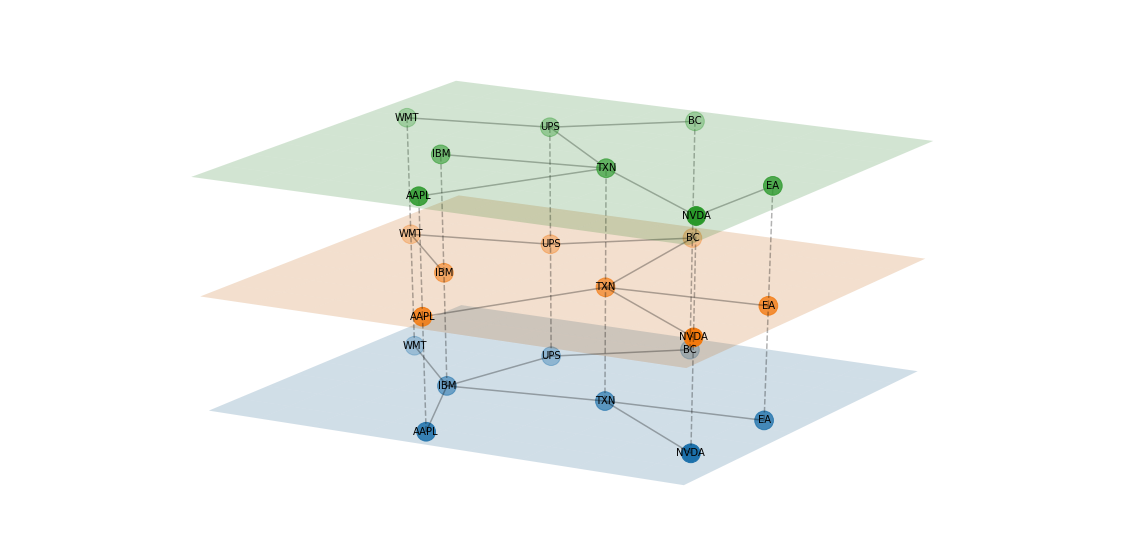

In [10]:
# adapted from: https://stackoverflow.com/questions/60392940/multi-layer-graph-in-networkx

class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefore, we compute the layout for the full network in 2D, and then apply the positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the trick.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=350, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)


if __name__ == '__main__':
    
    # define graphs
    n = 1
    g = mst_dict[1]
    h = mst_dict[946]
    i = mst_dict[1828]
    
    node_labels = {nn : str(nn) for nn in g.nodes}
    
    # initialise figure and plot
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')
    LayeredNetworkGraph([g, h, i], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
    ax.set_axis_off()
    plt.savefig('multilayered.png', bbox_inches='tight')
    plt.show()